In [1]:
#general imports
import math

import pandas as pd
import numpy as np

#statsmodels for regression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

#scipy for testing
from scipy import stats

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

## Importing the Bike Data

Imports the normal Data needed for every KPI

In [2]:
df_bikes = pd.read_csv('../data/philadelphia_2017.csv')
df_weather = pd.read_csv('../data/weather_hourly_philadelphia.csv')
df_geocodes = pd.read_csv('../data/geocodes.csv')

def get_datetime(date_string):
    if date_string.__contains__("/"):
        new_string = ""
        running_string = ""
        for char in date_string:
            if char == "/" or  char == ":" or char == " ":
                if len(running_string) == 1:
                    running_string = "0" + running_string
                new_string += running_string + char
                running_string = ""
            else:
                running_string += char
        new_string += running_string
        if len(new_string) > 16:
            return datetime.strptime(new_string, '%m/%d/%Y %H:%M:%S')
        else:
            return datetime.strptime(new_string, '%m/%d/%Y %H:%M')
    else:
        return datetime.fromisoformat(date_string)

def compare_datetime(start, end):
    start_datetime = get_datetime(start)
    end_datetime = get_datetime(end)
    duration_of_travel = end_datetime - start_datetime
    seconds = duration_of_travel.total_seconds()
    return seconds/60

ride_lengths = []
df_bikes["ride_duration_minutes"] = df_bikes.apply(lambda x: (compare_datetime(x["start_time"],x["end_time"])), axis=1)

for label, content in df_bikes.iterrows():
    ride_lengths.append(content["ride_duration_minutes"])

ride_lengths_np = np.array(ride_lengths)
iqr = stats.iqr(ride_lengths_np)
iqr

q1,q3 = np.percentile(ride_lengths_np, [25,95])

lower_range = q1 - (1.5*iqr)
upper_range = q3 + (1.5*iqr)

#A ride, can't be shorter than 0 Minutes obviously
if lower_range < 0:
    lower_range = 0

df_bikes.drop(df_bikes[ (df_bikes.ride_duration_minutes > upper_range) | (df_bikes.ride_duration_minutes < lower_range) ].index , inplace=True)


In [3]:
df_bikes.insert(2, 'usage', 1)

In [4]:
df_bikes['end_time_rounded'] = get_datetime(df_bikes["end_time"][0]).replace(minute=0)

In [5]:
s = 0
z = 1
for x in range(0,788906):
    if x not in df_bikes.index:
        s = s + 1
        if s == 1000*z:
            print(x)
            z = z + 1
        else:
            pass
    else:
        df_bikes['end_time_rounded'][x] = get_datetime(df_bikes["end_time"][x]).replace(minute=0)

<ipython-input-5-68b4343a476b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikes['end_time_rounded'][x] = get_datetime(df_bikes["end_time"][x]).replace(minute=0)


45795
66133
108591
131887
155306
184846
217251
238406
268642
293197
321602
343296
369865
399242
432102
457399
487616
519325
541169
576939
607341
646208
677934
712174
758304


In [6]:
df_bikes['end_time_rounded'] = df_bikes['end_time_rounded'].dt.strftime("%y/%m/%d %H")



In [7]:
df_bikes_usage = df_bikes.groupby(['end_time_rounded','bike_id']).count().reset_index()
df_bikes_usage.drop(['start_station_id', 'end_station_id', 'start_time', 'end_time', 'user_type', 'start_station_name', 'end_station_name', 'ride_duration_minutes'], axis=1)

,end_time_rounded,bike_id,usage
0,17/01/01 00,2479,1
1,17/01/01 00,2536,1
2,17/01/01 00,2557,1
3,17/01/01 00,3296,1
4,17/01/01 00,3364,1
...,...,...,...
683187,17/12/31 23,3512,1
683188,17/12/31 23,3677,1
683189,17/12/31 23,3708,1
683190,17/12/31 23,6725,1


In [8]:
df_bikes_usage.describe()

,bike_id,start_time,end_time,usage,start_station_id,end_station_id,user_type,start_station_name,end_station_name,ride_duration_minutes
count,683192.000000,683192.000000,683192.000000,683192.000000,683192.000000,683192.000000,683192.000000,683192.000000,683192.000000,683192.000000
mean,5393.885924,1.117150,1.117150,1.117150,1.117150,1.117150,1.117150,1.117150,1.117150,1.117150
std,3206.580530,0.348967,0.348967,0.348967,0.348967,0.348967,0.348967,0.348967,0.348967,0.348967
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3346.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3694.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,5366.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,11965.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


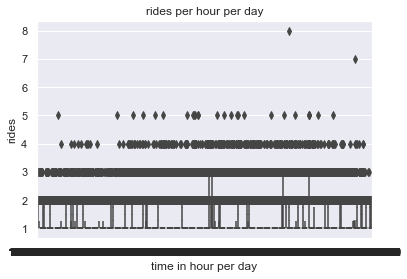

In [9]:
sns.set_theme(style="darkgrid")
bike_boxplot = sns.boxplot(x="end_time_rounded", y="usage", data=df_bikes_usage)
bike_boxplot.set_xlabel('time in hour per day')
bike_boxplot.set_ylabel('rides')
bike_boxplot.set_title("rides per hour per day")
plt.savefig('vis_bike_user_hours.pdf')
plt.show()